In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from keras import layers
import numpy as np
from keras.callbacks import EarlyStopping
from tensorflow import nn
from sklearn.preprocessing import normalize
from glob import glob
import os

Using TensorFlow backend.


In [2]:
print(tf.config.list_physical_devices('GPU'))
tf.version.VERSION

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


'2.4.0'

In [3]:
path = "W:\Advanced Engineering\Vortex Ballistics\Gel Images\Model Training"
HEIGHT = 384//10
WIDTH = 576//10
trainFile = '03- train- Img only'
testFile = '04- test- Img only'
BATCH_SIZE = 8

[[  7  11  24 ...  25  10   7]
 [ 10 145 150 ... 150 143  10]
 [ 24 154 142 ... 143 155  27]
 ...
 [ 24 154 142 ... 143 155  27]
 [ 10 145 150 ... 150 143  10]
 [  7  11  24 ...  25  10   7]]


(384, 576)

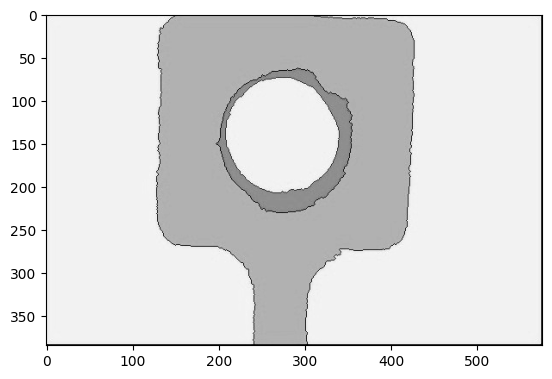

In [4]:
# file = "W:\Advanced Engineering\Vortex Ballistics\Gel Images\Model Training\\train\Outputs\img\IMG_0467_blurred.JPG"
# img = cv2.imread(file)
# plt.imshow(img)
# img.shape

file = "W:\Advanced Engineering\Vortex Ballistics\Gel Images\Model Training/03- train- Img only\Watershed Out\img\IMG_00074.jpg"
img = cv2.imread(file, 0)
print(img)
plt.imshow(img, cmap='gray')
img.shape[:]

In [5]:
def load_data(path):
    train_x = sorted(glob(os.path.join(path, trainFile, 'Input', 'img', '*.jpg')))
    train_y = sorted(glob(os.path.join(path, trainFile, 'Ring Mask', 'img', '*.jpg')))

    test_x = sorted(glob(os.path.join(path, testFile, 'Input', 'img', '*.jpg')))
    test_y = sorted(glob(os.path.join(path, testFile, 'Ring Mask', 'img', '*.jpg')))

    return (train_x, train_y), (test_x, test_y)

In [6]:
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = x/255.0
    x = np.expand_dims(x, axis=-1)
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = x/255.0
    x = np.expand_dims(x, axis=-1)
    return x

In [7]:
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y
    
    x, y = tf.numpy_function(_parse, [x, y], [tf.float64, tf.float64])
    x.set_shape([HEIGHT, WIDTH, 1])
    y.set_shape([HEIGHT, WIDTH, 1])

    return x,y

In [8]:
def tf_dataset(x, y, batch = BATCH_SIZE):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [9]:
(train_x, train_y), (test_x, test_y) = load_data(path)
print(f"Train: {len(train_x)} - {len(train_y)}")
print(f"Train: {len(test_x)} - {len(test_y)}")

Train: 561 - 561
Train: 186 - 186


In [10]:
train_dataset = tf_dataset(train_x, train_y, batch=BATCH_SIZE)
test_dataset = tf_dataset(test_x, test_y, batch=BATCH_SIZE)

In [11]:
for x, y in test_dataset:
    print(x.shape, y.shape)

InvalidArgumentError: Incompatible shapes at component 0: expected [?,38,57,1] but got [8,384,576,1].

In [ ]:
def double_conv_block(x, out_channels):
    x = layers.Conv2D(filters= out_channels, kernel_size=3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters= out_channels, kernel_size=3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x 

In [ ]:
def downsample_block(x, out_channels):
    f = double_conv_block(x, out_channels)
    p = layers.MaxPool2D(pool_size=2, strides=2)(f)
    #p = layers.Dropout(0.5)(p)
    return f, p

In [ ]:
def upsample_block(x, conv_features, out_channels):
    x = layers.Conv2DTranspose(filters = out_channels, kernel_size=2, strides=2, padding='same')(x)
    x = layers.concatenate(inputs=[x, conv_features])
    #x = layers.Dropout(0.5)(x)
    x = double_conv_block(x, out_channels)
    return x

In [ ]:
def build_unet_model():
    inputs = layers.Input(shape=(img.shape[0], img.shape[1], 1))

    f1, p1 = downsample_block(inputs, 64)
    f2, p2 = downsample_block(p1, 128)
    f3, p3 = downsample_block(p2, 256)
    f4, p4 = downsample_block(p3, 512)

    bottleneck = double_conv_block(p4, 1024)

    u6 = upsample_block(bottleneck, f4, 512)
    u7 = upsample_block(u6, f3, 256)
    u8 = upsample_block(u7, f2, 128)
    u9 = upsample_block(u8, f1, 64)

    #outputs = layers.Conv2D(filters = 1, kernel_size=1, padding='same', activation = "relu")(u9)
    outputs = layers.Conv2D(filters = 1, kernel_size=1, padding='same', activation = "sigmoid")(u9)


    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
    return unet_model



In [ ]:
unet_model = build_unet_model()
unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 384, 576, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 384, 576, 64)         640       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 384, 576, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 re_lu (ReLU)                (None, 384, 576, 64)         0         ['batch_normalization[0][0

In [ ]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                   loss= "binary_crossentropy",
                   #loss = 'mse',
                   metrics=["acc"])

es = EarlyStopping(monitor='val_loss', mode='min', patience=3, verbose=1, restore_best_weights=False)

In [ ]:
BUFFER_SIZE = 1000
NUM_EPOCHS = 5

TRAIN_LENGTH = 213
#STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
STEPS_PER_EPOCH = 13

VAL_SUBSPLITS = 5
TEST_LENTH = 27
#VALIDATION_STEPS = TEST_LENTH // BATCH_SIZE // VAL_SUBSPLITS
VALIDATION_STEPS = 5

#model_history = unet_model.fit(train_generator,
#                               epochs=NUM_EPOCHS,
#                               steps_per_epoch= sampleSize//BATCH_SIZE,
#                               validation_steps=VALIDATION_STEPS,
#                               validation_data=test_generator,
#                               #callbacks=[es]
#                              )

model_history = unet_model.fit(train_dataset,
                               epochs=NUM_EPOCHS,
                               #steps_per_epoch= sampleSize//BATCH_SIZE,
                               #validation_steps=VALIDATION_STEPS,
                               validation_data=test_dataset,
                               #callbacks=[es]
                               )

Epoch 1/5
 1/71 [..............................] - ETA: 39:08 - loss: 0.8259 - acc: 0.3205

KeyboardInterrupt: 

In [ ]:
tf.config.list_physical_devices("GPU")

[]

In [ ]:
testFile = "W:\Advanced Engineering\Vortex Ballistics\Gel Images\Model Training/00- Full Image Dataset\IMG_02010.JPG"
testImg = image.load_img(testFile, color_mode='grayscale')
testImg = np.expand_dims(testImg, axis=0)
testImg = testImg/255
testImg = testImg
imOut = unet_model.predict(testImg)

1/1 [==============================] - 1s 900ms/step


[[0.4903858  0.4854344  0.48950616 ... 0.48747802 0.4866072  0.48722038]
 [0.48263067 0.48117122 0.46790496 ... 0.47972253 0.47781155 0.4877458 ]
 [0.4824562  0.47744066 0.47885162 ... 0.47909632 0.47885218 0.49352974]
 ...
 [0.48190022 0.47945043 0.46271202 ... 0.4757376  0.4717265  0.4911222 ]
 [0.47661856 0.4855156  0.46804097 ... 0.48549175 0.47089472 0.4936313 ]
 [0.48433223 0.4888043  0.48500714 ... 0.48100495 0.48597077 0.48658836]]


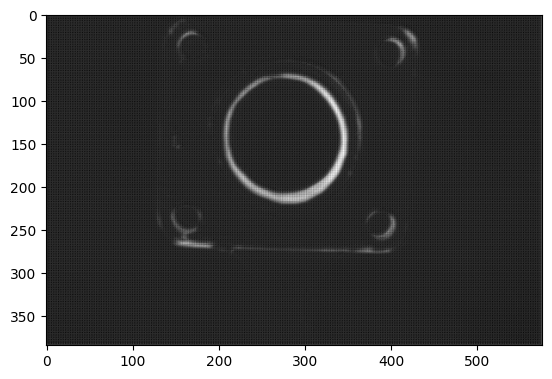

In [ ]:
imOut = imOut.reshape(testImg.shape[1:3])
print(imOut)
normalizedArr = tf.keras.utils.normalize(imOut)
predicted_mask = (normalizedArr > .000001).astype(np.uint32)
plt.imshow(imOut, cmap='gray')